# Project 1: Exploratory Data Analysis & Inference on smartwatch_health dataset.
**Goal:** Demonstrate statistical reasoning through data cleaning and EDA on a 10,000-row smartwatch_health dataset.

### 1. Initial Setup and Structure Inspection
We begin by identifying the measurement scales and data types. This stage allows us to detect possible type mismatch and initial missingness patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (already in the same directory)
df = pd.read_csv("unclean_smartwatch_health_data.csv")

# Structure Check
print("--- Data Structure ---")
print(df.info())

# Calculate missing value count
counts = df.isnull().sum()
percents = (df.isnull().sum() / len(df)) * 100
missing_data = pd.concat([counts, percents], axis=1)
missing_data.columns = ['Missing Count', 'Percentage (%)']
print(missing_data)

--- Data Structure ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9799 non-null   float64
 1   Heart Rate (BPM)        9600 non-null   float64
 2   Blood Oxygen Level (%)  9700 non-null   float64
 3   Step Count              9900 non-null   float64
 4   Sleep Duration (hours)  9850 non-null   object 
 5   Activity Level          9800 non-null   object 
 6   Stress Level            9800 non-null   object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB
None
                        Missing Count  Percentage (%)
User ID                           201            2.01
Heart Rate (BPM)                  400            4.00
Blood Oxygen Level (%)            300            3.00
Step Count                        100            1.00
Sleep Duration (hours)            150            1.50
Activity L

### 2. Investigating Data Quality Issues
* **Missing Values:** Significant gaps across all columns; `Heart Rate (BPM)` is the most affected (400 records).
* **Type Corruption:** `Sleep Duration` and `Stress Level` are stored as `object` types, indicating non-numeric characters are breaking the numerical schema.
* **Activity Validation:** `Activity Level` is stored as an `object`; we must verify if values fall within the expected categorical range.

In the following code, we will try further investigation to consider how to solve the mentioned issues.(for easier demonstration, we will seperate into Categorical part and Numerical par )

#### Categorical part

In [2]:
# Checking unique ID excluding NaN
print("Unique User ID count:", df['User ID'].nunique())
# Object Dtype Check:
""" We can using .unique() function here as these features have small range of value 
(being Likert Scales and similar to Satisfaction)"""
print("\nAll Unique values of Activity Level:\n", df['Activity Level'].unique())
print("\nAll Unique values of Stress Level:\n", df['Stress Level'].unique())

Unique User ID count: 3634

All Unique values of Activity Level:
 ['Highly Active' 'Highly_Active' 'Actve' 'Seddentary' 'Sedentary' 'Active'
 nan]

All Unique values of Stress Level:
 ['1' '5' '3' '6' '10' '2' '8' '9' nan '4' 'Very High' '7']


* **User ID Reliability & Duplication Risk** 

Out of 10,000 total records, only 3,634 unique User IDs exist, despite 9,799 non-null entries in that column. This indicates that approximately 64% of the dataset consists of repeat entries for the same users. We must investigate whether these represent the same user tracked over multiple times or if they are the result of a data collection error.

In [3]:
# Check for completely identical rows
duplicate_rows = df.duplicated().sum()
print(f"Number of completely identical rows: {duplicate_rows}")
# Change User ID to string (Nominal Label)
df['User ID'] = df['User ID'].astype(str)

Number of completely identical rows: 0


Number of completely identical rows = 0, this suggest that same person recorded multiple times, which can be consider normal case as smartwatch normally collect data continiously. 

* **Categorical Mismatches & Structural Noise:** 

**Activity Level** contains several manual entry errors that require immediate normalization to ensure accurate grouping. Specifically, we will map labels like Highly Active $\rightarrow$ Highly_Active, Seddentary $\rightarrow$ Sedentary, and Actve $\rightarrow$ Active.

**Stress Level** contains a Very High category that deviates from the standard scale. At this stage, we will analysis deeper distribution analysis.

49


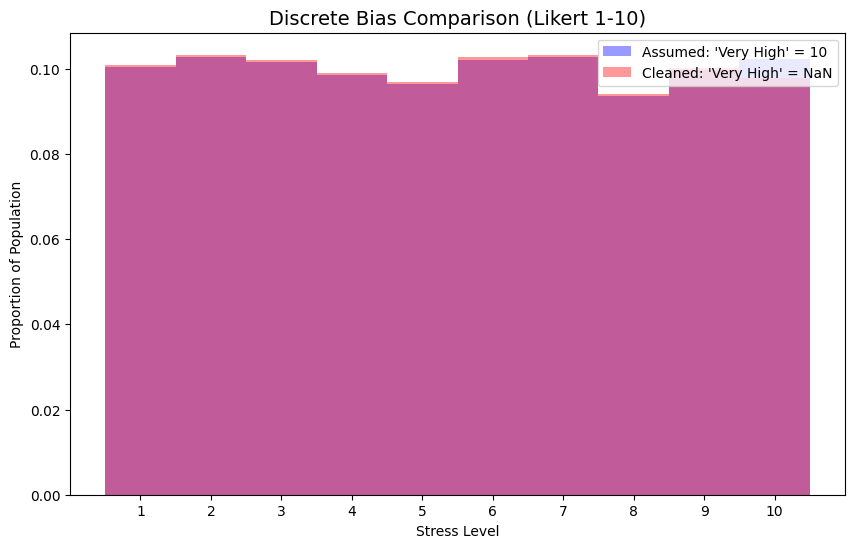

In [6]:
print((df['Stress Level'] == 'Very High').sum())

# Since Stress Level is a 1-10 Likert scale (Discrete), we use a Histogram with 10 bins
plt.figure(figsize=(10, 6))

# Define common bins for 1-10 scale
bins = np.arange(1, 12) - 0.5 

# Create two versions for comparison
stress_as_10 = pd.to_numeric(df['Stress Level'].replace('Very High', 10), errors='coerce')
stress_as_nan = pd.to_numeric(df['Stress Level'], errors='coerce')

# Plot Scenario A (Very High = 10)
plt.hist(stress_as_10.dropna(), bins=bins, alpha=0.4, label="Assumed: 'Very High' = 10", color='blue', density=True)
# Plot Scenario B (Very High = NaN)
plt.hist(stress_as_nan.dropna(), bins=bins, alpha=0.4, label="Cleaned: 'Very High' = NaN", color='red', density=True)

plt.title("Discrete Bias Comparison (Likert 1-10)", fontsize=14)
plt.xticks(range(1, 11))
plt.xlabel("Stress Level")
plt.ylabel("Proportion of Population")
plt.legend()
plt.show()

Since the difference in each levels is low, the bar for each levels barely moves, we chose coercion to NaN. This maintains high Statistical Integrity by removing ambiguous text without distorting the overall population density

### Final Cleaning Pipeline & NaN Conversion will be included in section 3.

#### Numerical part
* **Data risk** We are investigating a potential discrepancy between automated sensor data and manual user input.
* **Out of range** We performed a boundary check on key health metrics to identify physiological impossibilities.
* **Fix data mismatch** From the first section(initial inspection), we see Sleep Duration is object type which implies there is string values mixing with numerical value.

In [ ]:
# Since we know Sleep Duration should be numerical and not negative, we need to finds anything that is NOT numeric
non_numeric = df[df['Sleep Duration (hours)'].str.contains(r'[^0-9\.]', na=False)]
print(non_numeric['Sleep Duration (hours)'].value_counts())

# Checking for precision (Human Bias vs Sensor Data)
int_heart = (df['Heart Rate (BPM)'].dropna() % 1 == 0).value_counts()
print(f"\nInteger values count: {int_heart}")
int_blood = (df['Blood Oxygen Level (%)'].dropna() % 1 == 0).value_counts()
print(f"\nInteger values count: {int_blood}")
int_step = (df['Step Count'].dropna() % 1 == 0).value_counts()
print(f"\nInteger values count: {int_step}")

Sleep Duration (hours)
ERROR                  247
-0.1944527906201543      1
Name: count, dtype: int64

Integer values count: Heart Rate (BPM)
False    9516
True       84
Name: count, dtype: int64

Integer values count: Blood Oxygen Level (%)
False    8174
True     1526
Name: count, dtype: int64

Integer values count: Step Count
False    9900
Name: count, dtype: int64


* **Data Precision & Range Audit** 
- Since Sleep Duration's mismatch is 248/10000 is around ~2.48%, we decide to change it to NaN.
- Heart Rate (BPM): Only 84 entries are integers ($<1\%$).
- Blood Oxygen (%): 1,526 entries are integers (~15%)
- Step Count: Correctly identified as 100% decimal-free (all floats represent whole numbers).

We will further investigate if those integers are caps, like Blood Oxygen Level (%) naturally cap at an integer ($100\%$) or due to human rounding.

In [ ]:
is_int_heart = (df['Heart Rate (BPM)'].dropna() % 1 == 0)
actual_int_heart = df['Heart Rate (BPM)'].dropna()[is_int_heart]

# 3. Now count those actual values
heart_rate_counts = actual_int_heart.astype(int).value_counts()
print("\n" , heart_rate_counts)

is_int_blood = (df['Blood Oxygen Level (%)'].dropna() % 1 == 0)
actual_int_blood = df['Blood Oxygen Level (%)'].dropna()[is_int_blood]
blood_rate_counts = actual_int_blood.astype(int).value_counts()
print("\n" , blood_rate_counts)


 Heart Rate (BPM)
40    84
Name: count, dtype: int64

 Blood Oxygen Level (%)
100    1526
Name: count, dtype: int64


Since those number appears to be at caps, we consider no data issues in this regard (Measurement bias).

In [ ]:
# Out of range (Heart Rate should be between 40 and 220)
Heart_out_of_range = df[(df['Heart Rate (BPM)'] < 40) | (df['Heart Rate (BPM)'] > 220)]
print(f"\nHeart Rate out-of-range:",  len(Heart_out_of_range)/len(df)*100, "%")
print(Heart_out_of_range['Heart Rate (BPM)'].unique())

# Blood Oxygen Level (%) should be between 88 and 100
Blood_out_of_range = df[(df['Blood Oxygen Level (%)'] < 88) | (df['Blood Oxygen Level (%)'] > 100)]
print(f"\nBlood Oxygen Level out-of-range:",  len(Blood_out_of_range)/len(df)*100, "%")
print(Blood_out_of_range['Blood Oxygen Level (%)'].unique())

# Step Count should be between 0 and 285000 (highest recorded distance walked in 24 hours)
out_of_range = df[(df['Step Count'] < 0) | (df['Step Count'] > 285000)]
print(f"\nStep Count out-of-range:",  len(out_of_range)/len(df)*100, "%")
print(out_of_range['Step Count'].unique())


Heart Rate out-of-range: 0.38999999999999996 %
[247.80305229 232.94490693 264.46735634 226.25672509 265.54290951
 228.49807798 256.37737736 283.58578538 292.92329956 282.86312404
 243.87697796 284.05525491 271.4957856  231.25544172 276.12398317
 296.59396951 249.61729139 269.14597467 250.62067876 246.09414448
 264.64281152 231.03628717 234.84093574 274.29690416 257.82968588
 263.37578972 283.48314311 250.84882498 256.00694521 252.99805186
 288.25776091 291.40307732 231.69677851 223.34751405 265.02996728
 293.2217564  232.12882843 273.86234831 251.49052945]

Blood Oxygen Level out-of-range: 0.0 %
[]

Step Count out-of-range: 0.0 %
[]


- Outlier Detection: Negligible out-of-range records detected ($<0.4\%$). We decide to change those to NaN.

## 3. Cleaning Decisions & Justification
Based on the investigation above, we apply the following rules to ensure **Statistical Integrity**:

1. **Coercion:** We will force `Sleep Duration` and `Stress Level` to numeric types. Any non-numeric "text" or out-of-range entries will be converted to `NaN`.
2. **Missing Data Strategy:** While missingness is low (<5%), we acknowledge a risk of bias if the missing data is not random. We chose to keep these as NAs to preserve the integrity of the observed distributions..
3. **Type Casting:** `User ID` will be treated as **Nominal** (label) to prevent accidental mathematical operations (like calculating a "Mean ID").

In [ ]:
def finalize_cleaning(data):
    df_c = data.copy()

    # 1. User ID: Cast to String
    df_c['User ID'] = df_c['User ID'].astype(str).str.replace('.0', '', regex=False)
    
    # 2. Activity Level: Normalize ALL 4 categories
    activity_map = {
        'Highly Active': 'Highly_Active',
        'Seddentary': 'Sedentary',
        'Actve': 'Active',
        'Highly_Active': 'Highly_Active',
        'Sedentary': 'Sedentary', 
        'Active': 'Active'
    }
    df_c['Activity Level'] = df_c['Activity Level'].str.strip().map(activity_map)
    
    # Set as 4 categories in order
    activity_order = ['Sedentary', 'Active', 'Highly_Active']
    df_c['Activity Level'] = pd.Categorical(df_c['Activity Level'], 
                                            categories=activity_order, 
                                            ordered=True)
    
    # 3. Numeric Coercion (Stress & Sleep)
    cols_to_fix = ['Sleep Duration (hours)', 'Stress Level']
    for col in cols_to_fix:
        df_c[col] = pd.to_numeric(df_c[col], errors='coerce')
        
    # Fix negative sleep values
    df_c.loc[df_c['Sleep Duration (hours)'] < 0, 'Sleep Duration (hours)'] = np.nan
        
    # 4. Heart Rate: Fix range
    mask = df_c['Heart Rate (BPM)'].between(40, 220)
    df_c.loc[~mask, 'Heart Rate (BPM)'] = np.nan
    
    return df_c

# Apply and verify
df_clean = finalize_cleaning(df)

# --- Verification ---
print("--- Final Data Types ---")
print(df_clean.dtypes)
print("\n--- Missing Values after NaN Conversion ---")
print(df_clean[['Stress Level', 'Sleep Duration (hours)', 'Heart Rate (BPM)']].isnull().sum())
print("\n--- Activity Level Categories ---")
print(df_clean['Activity Level'].unique())
print("Normalized Activity Level counts:")
print(df_clean['Activity Level'].value_counts().sort_index())

--- Final Data Types ---
User ID                     object
Heart Rate (BPM)           float64
Blood Oxygen Level (%)     float64
Step Count                 float64
Sleep Duration (hours)     float64
Activity Level            category
Stress Level               float64
dtype: object

--- Missing Values after NaN Conversion ---
Stress Level              249
Sleep Duration (hours)    398
Heart Rate (BPM)          439
dtype: int64

--- Activity Level Categories ---
['Highly_Active', 'Active', 'Sedentary', NaN]
Categories (3, object): ['Sedentary' < 'Active' < 'Highly_Active']
Normalized Activity Level counts:
Activity Level
Sedentary        3333
Active           3265
Highly_Active    3202
Name: count, dtype: int64


###  Exploratory Data Analysis(EDA)

#### Categorical Exploration

#### Univariate Exploration

#### Bivariate Exploration

#### EDA Summary

#### Descriptive Statistics

#### Choice of Summary Statistics

#### Conclusion